In [1]:
%load_ext autoreload

In [7]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from iaaft import surrogates
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Testing Spec

In [183]:
area = 'vlPFC'
if area == 'all':
    area_indices = np.arange(len(electrode_info['area']))
else:
    area_indices = np.where(electrode_info['area'] == area)[0]

big_window_start = 30*60 # s
big_window_length = 100 # s
big_window_start_ind = int(big_window_start/dt)
big_window_end_ind = big_window_start_ind + int(big_window_length/dt)
big_signal = lfp[big_window_start_ind:big_window_end_ind, area_indices]
signal_in = big_signal[:, 0]

In [184]:
nperseg = 1000
f, t, Zxx = scipy.signal.stft(signal_in, fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)

In [185]:
Zxx_mag = np.zeros(Zxx.shape)
Zxx_phase = np.zeros(Zxx.shape)
for i in range(Zxx.shape[0]):
    for j in range(Zxx.shape[1]):
        Zxx_mag[i, j], Zxx_phase[i, j] = cmath.polar(Zxx[i, j])

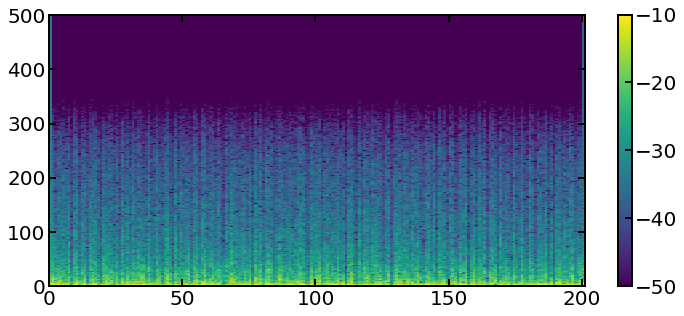

In [186]:
plt.figure(figsize=(12, 5))
plt.pcolormesh(10*np.log10(Zxx_mag))
# print(plt.get_xticks())
plt.clim([-50, -10])
plt.colorbar()
plt.show()

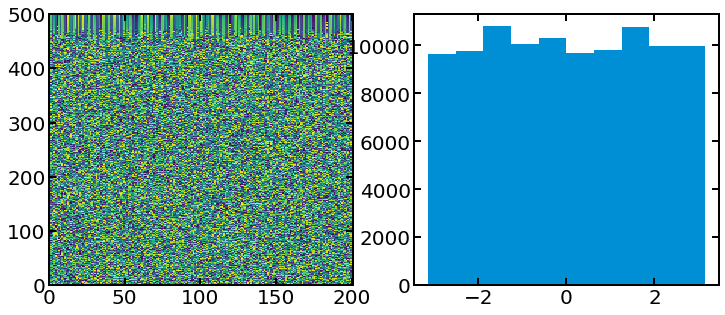

In [187]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(Zxx_phase)
plt.subplot(1, 2, 2)
plt.hist(Zxx_phase.flatten())
plt.show()

In [188]:
Zxx_phase_random = np.random.uniform(low=Zxx_phase.min(), high=Zxx_phase.max(), size=Zxx_phase.shape)
Zxx_phase_flat = np.zeros(Zxx_phase.shape)

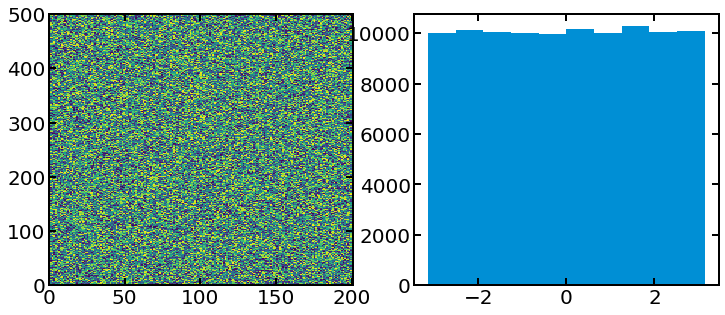

In [189]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(Zxx_phase_random)
plt.subplot(1, 2, 2)
plt.hist(Zxx_phase_random.flatten())
plt.show()

In [190]:
#reconstruct
Zxx_random = np.zeros(Zxx.shape, dtype=complex)
Zxx_flat = np.zeros(Zxx.shape, dtype=complex)
for i in range(Zxx.shape[0]):
    for j in range(Zxx.shape[1]):
        Zxx_random[i, j] = Zxx_mag[i, j]*np.exp(complex(0, Zxx_phase_random[i, j]))
        Zxx_flat[i, j] = Zxx_mag[i, j]*np.exp(complex(0, Zxx_phase_flat[i, j]))

In [191]:
t, x_inverted = scipy.signal.istft(Zxx, fs=1/dt, nperseg=nperseg)
t, x_inverted_random = scipy.signal.istft(Zxx_random, fs=1/dt, nperseg=nperseg)
t, x_inverted_flat = scipy.signal.istft(Zxx_flat, fs=1/dt, nperseg=nperseg)

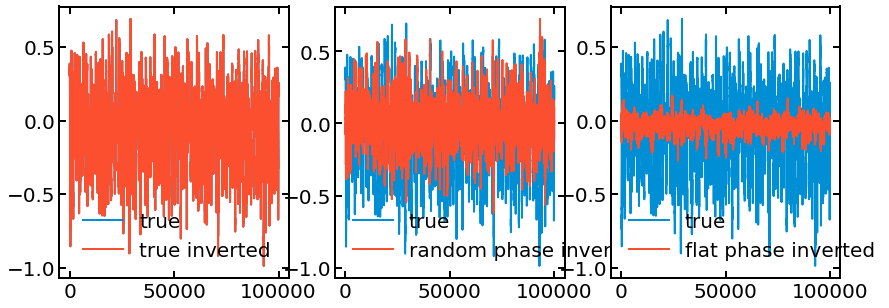

In [192]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(signal_in, label="true")
plt.plot(x_inverted, label="true inverted")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(signal_in, label="true")
plt.plot(x_inverted_random, label="random phase inverted")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(signal_in, label="true")
plt.plot(x_inverted_flat, label="flat phase inverted")
plt.legend()
plt.show()

In [193]:
f, t, Zxx_random_v2 = scipy.signal.stft(x_inverted_random, fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
f, t, Zxx_flat_v2 = scipy.signal.stft(x_inverted_flat, fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)

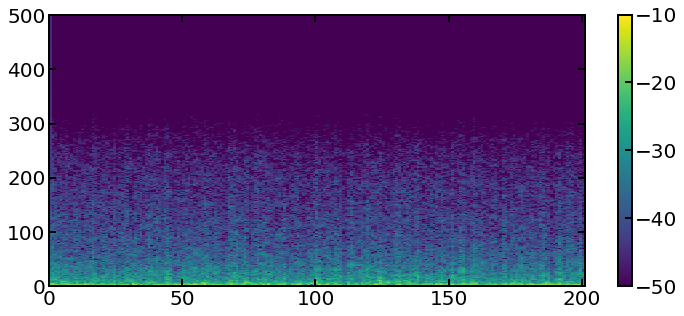

In [194]:
plt.figure(figsize=(12, 5))
# plt.pcolormesh(10*np.log10(np.abs(Zxx_random_v2)))
plt.pcolormesh(10*np.log10(np.abs(Zxx_flat_v2)))
# print(plt.get_xticks())
plt.clim([-50, -10])
plt.colorbar()
plt.show()

# Constructing Signals

In [8]:
area = 'vlPFC'
if area == 'all':
    area_indices = np.arange(len(electrode_info['area']))
else:
    area_indices = np.where(electrode_info['area'] == area)[0]

big_window_start = 30*60 # s
big_window_length = 100 # s
big_window_start_ind = int(big_window_start/dt)
big_window_end_ind = big_window_start_ind + int(big_window_length/dt)
signal_in = lfp[big_window_start_ind:big_window_end_ind, area_indices]

In [18]:
signal_in_surrogate = np.zeros(signal_in.shape)
for i in tqdm(range(signal_in.shape[1])):
    signal_in_surrogate[:, i] = surrogates(signal_in[:, i], 1, verbose=False)[0]

  0%|          | 0/64 [00:00<?, ?it/s]

In [94]:
signal_in_shuffled = np.zeros(signal_in.shape)
for i in tqdm(range(signal_in.shape[1])):
    signal_in_shuffled[:, i] = signal_in[np.random.permutation(np.arange(signal_in.shape[0])), i]

  0%|          | 0/64 [00:00<?, ?it/s]

In [69]:
signal_in_random = np.zeros(signal_in.shape)
signal_in_flat = np.zeros(signal_in.shape)
signal_in_normal = np.zeros(signal_in.shape)
signal_in_mag_avg = np.zeros(signal_in.shape)
signal_in_mag_avg_random = np.zeros(signal_in.shape)
signal_in_mag_avg_flat = np.zeros(signal_in.shape)
signal_in_mag_avg_normal = np.zeros(signal_in.shape)
signal_in_sliding_avg = np.zeros(signal_in.shape)
signal_in_sliding_avg_random = np.zeros(signal_in.shape)
nperseg = 1000
for unit_ind in tqdm(range(signal_in.shape[1])):
    # compute spectrogram
    f, t, Zxx = scipy.signal.stft(signal_in[:, unit_ind], fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
    
    # split into phase and mag
    Zxx_mag = np.zeros(Zxx.shape)
    Zxx_phase = np.zeros(Zxx.shape)
    for i in range(Zxx.shape[0]):
        for j in range(Zxx.shape[1]):
            Zxx_mag[i, j], Zxx_phase[i, j] = cmath.polar(Zxx[i, j])
    
    Zxx_phase_random = np.random.uniform(low=Zxx_phase.min(), high=Zxx_phase.max(), size=Zxx_phase.shape)
    Zxx_phase_flat = np.zeros(Zxx_phase.shape)
    Zxx_phase_normal = np.random.normal(loc=0, scale=np.pi/2, size=Zxx_phase.shape)
    
    Zxx_mag_avg = np.zeros(Zxx_mag.shape)
    for i in range(Zxx_mag.shape[0]):
        Zxx_mag_avg[i] = Zxx_mag[i].mean()
        
    avg_window = 20
    Zxx_mag_sliding_avg = np.zeros(Zxx.shape)
    for i in range(Zxx_mag.shape[0]):
        for j in range(Zxx_mag.shape[1]):
            if j == 0:
                Zxx_mag_sliding_avg[i, j] = Zxx_mag[i, 0]
            else:
                Zxx_mag_sliding_avg[i, j] = Zxx_mag[i, np.max([0, j - avg_window]):j].mean()
    
    #reconstruct
    Zxx_random = np.zeros(Zxx.shape, dtype=complex)
    Zxx_flat = np.zeros(Zxx.shape, dtype=complex)
    Zxx_normal = np.zeros(Zxx.shape, dtype=complex)
    Zxx_avg = np.zeros(Zxx.shape, dtype=complex)
    Zxx_avg_random = np.zeros(Zxx.shape, dtype=complex)
    Zxx_avg_flat = np.zeros(Zxx.shape, dtype=complex)
    Zxx_avg_normal = np.zeros(Zxx.shape, dtype=complex)
    Zxx_sliding_avg = np.zeros(Zxx.shape, dtype=complex)
    Zxx_sliding_avg_random = np.zeros(Zxx.shape, dtype=complex)
    for i in range(Zxx.shape[0]):
        for j in range(Zxx.shape[1]):
            Zxx_random[i, j] = Zxx_mag[i, j]*np.exp(complex(0, Zxx_phase_random[i, j]))
            Zxx_flat[i, j] = Zxx_mag[i, j]*np.exp(complex(0, Zxx_phase_flat[i, j]))
            Zxx_normal[i, j] = Zxx_mag[i, j]*np.exp(complex(0, Zxx_phase_normal[i, j]))
            
            Zxx_avg[i, j] = Zxx_mag_avg[i, j]*np.exp(complex(0, Zxx_phase[i, j]))
            Zxx_avg_random[i, j] = Zxx_mag_avg[i, j]*np.exp(complex(0, Zxx_phase_random[i, j]))
            Zxx_avg_flat[i, j] = Zxx_mag_avg[i, j]*np.exp(complex(0, Zxx_phase_flat[i, j]))
            Zxx_avg_normal[i, j] = Zxx_mag_avg[i, j]*np.exp(complex(0, Zxx_phase_normal[i, j]))
    
            Zxx_sliding_avg[i, j] = Zxx_mag_sliding_avg[i, j]*np.exp(complex(0, Zxx_phase[i, j]))
            Zxx_sliding_avg_random[i, j] = Zxx_mag_sliding_avg[i, j]*np.exp(complex(0, Zxx_phase_random[i, j]))
    
    t, x_inverted = scipy.signal.istft(Zxx, fs=1/dt, nperseg=nperseg)
    t, x_inverted_random = scipy.signal.istft(Zxx_random, fs=1/dt, nperseg=nperseg)
    t, x_inverted_flat = scipy.signal.istft(Zxx_flat, fs=1/dt, nperseg=nperseg)
    t, x_inverted_normal = scipy.signal.istft(Zxx_normal, fs=1/dt, nperseg=nperseg)
    t, x_inverted_mag_avg = scipy.signal.istft(Zxx_avg, fs=1/dt, nperseg=nperseg)
    t, x_inverted_mag_avg_random = scipy.signal.istft(Zxx_avg_random, fs=1/dt, nperseg=nperseg)
    t, x_inverted_mag_avg_flat = scipy.signal.istft(Zxx_avg_flat, fs=1/dt, nperseg=nperseg)
    t, x_inverted_mag_avg_normal = scipy.signal.istft(Zxx_avg_normal, fs=1/dt, nperseg=nperseg)
    t, x_inverted_sliding_avg = scipy.signal.istft(Zxx_sliding_avg, fs=1/dt, nperseg=nperseg)
    t, x_inverted_sliding_avg_random = scipy.signal.istft(Zxx_sliding_avg_random, fs=1/dt, nperseg=nperseg)
    
    signal_in_random[:, unit_ind] = x_inverted_random
    signal_in_flat[:, unit_ind] = x_inverted_flat
    signal_in_normal[:, unit_ind] = x_inverted_normal
    signal_in_mag_avg[:, unit_ind] = x_inverted_mag_avg
    signal_in_mag_avg_random[:, unit_ind] = x_inverted_mag_avg_random
    signal_in_mag_avg_flat[:, unit_ind] = x_inverted_mag_avg_flat
    signal_in_mag_avg_normal[:, unit_ind] = x_inverted_mag_avg_normal
    signal_in_sliding_avg[:, unit_ind] = x_inverted_sliding_avg
    signal_in_sliding_avg_random[:, unit_ind] = x_inverted_sliding_avg_random

  0%|          | 0/64 [00:00<?, ?it/s]

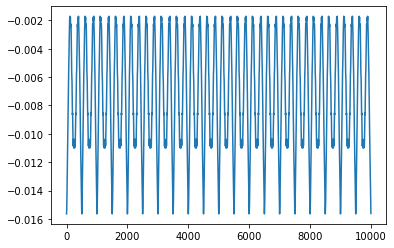

In [10]:
# plt.plot(x_inverted)
plt.plot(x_inverted_mag_avg_flat[:10000])
plt.show()

In [64]:
g = 1
N = 512
# W = np.random.randn(N, N)*g/np.sqrt(N)
# W_plus = np.clip(np.random.lognormal(mean=0, sigma = g/np.sqrt(N), size=(N, N)), amin=0)
W_plus = np.clip(np.random.randn(N, N)*g/np.sqrt(N), a_min=0, a_max=np.Inf)
D = np.diag(np.random.choice([1, -1], p = [0.8, 0.2], size=(N,)))
W = W_plus @ D
scales = np.arange(1, 2.1, 0.1)
lyap_exps = np.zeros((len(scales), N))
eigvals_real = np.zeros((len(scales), N))
eigvals_imag = np.zeros((len(scales), N))
for i, scale in enumerate(scales):
    W_new = W.copy()
    W_new[W < 0] = W[W < 0]*scale
#     W_new[W > 0] = W[W > 0]*scale
    e = np.linalg.eigvals(W_new)
    lyap_exps[i] = np.sort(np.real(e))
    eigvals_real[i] = np.real(e)
    eigvals_imag[i] = np.imag(e)

In [65]:
[np.sum(np.real(eigvals_real[i])) for i in range(eigvals_real.shape[0])]

[6.065191481218203,
 5.909741904013766,
 5.754292326809339,
 5.598842749604906,
 5.4433931724005955,
 5.287943595196199,
 5.132494017991785,
 4.977044440787516,
 4.821594863582984,
 4.666145286378596,
 4.510695709174199]

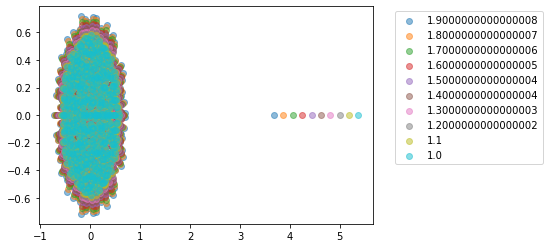

In [66]:
for i, scale in zip(np.arange(10)[::-1], scales[:-1][::-1]):
    plt.scatter(eigvals_real[i], eigvals_imag[i], label=scale, alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

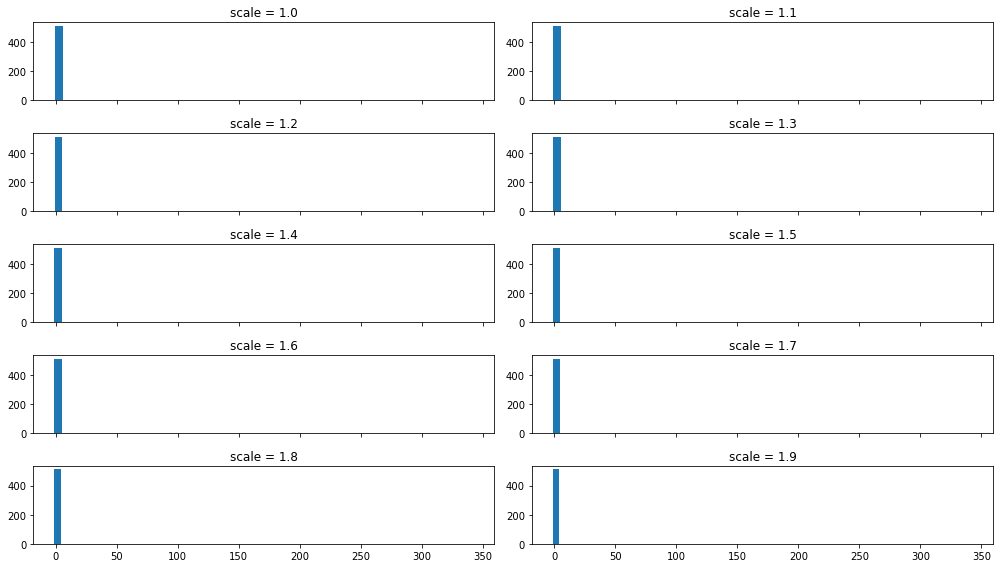

In [57]:
fig, axs = plt.subplots(5, 2, figsize=(14, 8), sharex=True)

for i in range(10):
    ax = axs[int(i/2)][i % 2]
    ax.hist(lyap_exps[i], bins=50)
    ax.set_title(f"scale = {scales[i]:.1f}")
plt.tight_layout()
plt.show()

In [278]:
# signal_in_random
correlations = {'random': [], 'flat': [], 'normal': [], 'mag_avg': [], 'mag_avg_random': [], 'mag_avg_flat': [], 'mag_avg_normal': []}
for i in range(signal_in.shape[1]):
    correlations['random'].append(scipy.stats.pearsonr(signal_in[:, i], signal_in_random[:, i])[0])
    correlations['flat'].append(scipy.stats.pearsonr(signal_in[:, i], signal_in_flat[:, i])[0])
    correlations['normal'].append(scipy.stats.pearsonr(signal_in[:, i], signal_in_normal[:, i])[0])
    
    correlations['mag_avg'].append(scipy.stats.pearsonr(signal_in[:, i], signal_in_mag_avg[:, i])[0])
    correlations['mag_avg_random'].append(scipy.stats.pearsonr(signal_in[:, i], signal_in_mag_avg_random[:, i])[0])
    correlations['mag_avg_flat'].append(scipy.stats.pearsonr(signal_in[:, i], signal_in_mag_avg_flat[:, i])[0])
    correlations['mag_avg_normal'].append(scipy.stats.pearsonr(signal_in[:, i], signal_in_mag_avg_normal[:, i])[0])
    

In [279]:
for key in correlations.keys():
    print(f"average {key} absolute correlation = {np.mean(np.abs(correlations[key]))}")

average random absolute correlation = 0.040764541844068115
average flat absolute correlation = 0.06684919879860765
average normal absolute correlation = 0.04467591990582791
average mag_avg absolute correlation = 0.911643992757338
average mag_avg_random absolute correlation = 0.029295850157155898
average mag_avg_flat absolute correlation = 0.03401607464244201
average mag_avg_normal absolute correlation = 0.0346092180630871


# VAR Grid Search

In [20]:
d = 10
indices = np.random.choice(np.arange(signal_in.shape[1]), size=(d, ), replace=False)

In [95]:
# data = signal_in[:,  indices]
# data = signal_in_surrogate[:, indices]
data = signal_in_shuffled[:, indices]
# data = signal_in_random[:,  indices]
# data = signal_in_flat[:,  indices]
# data = signal_in_normal[:, indices]
# data = signal_in_mag_avg[:, indices]
# data = signal_in_mag_avg_random[:, indices]
# data = signal_in_mag_avg_flat[:, indices]
# data = signal_in_sliding_avg[:, indices]

In [96]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
num_window_samples = 10

In [97]:
grid_search_df = []
iterator = tqdm(total = len(windows)*len(lags))
for window in windows:
    stride = window
    min_ind = int(0/stride)
    max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
    possible_inds = np.arange(min_ind, max_ind + 1)
    window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
#     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
    for p in lags:
#         for i in range(num_windows):
        for i in window_inds:
            start_ind = i*int(stride/dt)
            start_time = i*stride
            end_ind = i*int(stride/dt) + int(window/dt)
            end_time = i*stride + window
            if end_ind + T_pred <= data.shape[0]:
                
                window_data = data[start_ind:end_ind]
                results = compute_VAR_p(window_data, p)
                test_data = data[end_ind - p:end_ind + T_pred]

                train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                train_mse = ((train_prediction - train_true_vals)**2).mean()
                test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
                test_mse = ((test_prediction - test_true_vals)**2).mean()
                persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                # ADD TO DICTIONARY
                results['train_mse'] = train_mse
                results['test_mse'] = test_mse
                results['persistence_baseline'] = persistence_baseline

                # ADD TIMESTAMPS
                results['start_ind'] = start_ind
                results['end_ind'] = end_ind
                results['start_time'] = start_time
                results['end_time'] = end_time

                # ADD PARAMETERS
                results['window'] = window
                results['stride'] = stride
                results['p'] = p
                results['T_pred'] = T_pred
                
                grid_search_df.append(results)
        iterator.update()
iterator.close()
grid_search_df = pd.DataFrame(grid_search_df)

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

In [42]:
def pick_2d_optimum(mat, thresh=0.95):
    true_min = mat.min()
    i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
    selected_i = np.min(i_vals)
    selected_j = np.min(j_vals[i_vals == selected_i])
    selected_i, selected_j

    return selected_i, selected_j
thresh = 1
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)

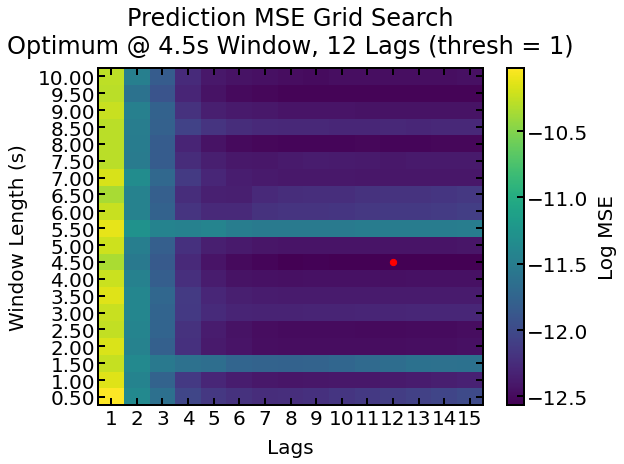

In [43]:
log_test_mse_mat = np.log(test_mse_mat)
plt.style.use('../../sci_style.py')
plt.figure(figsize=(9, 6))
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [f"{windows[i]:.2f}" for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.show()

# Compute VAR Results

In [44]:
window = windows[w_ind]
p = lags[p_ind]

In [45]:
VAR_results = []
stride = window
num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
for i in tqdm(range(num_windows)):
    start_ind = i*int(stride/dt)
    start_time = i*stride
    end_ind = i*int(stride/dt) + int(window/dt)
    end_time = i*stride + window
    if end_ind + T_pred <= data.shape[0]:

        window_data = data[start_ind:end_ind]
        results = compute_VAR_p(window_data, p)
        test_data = data[end_ind - p:end_ind + T_pred]

        train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
        train_mse = ((train_prediction - train_true_vals)**2).mean()
        test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
        test_mse = ((test_prediction - test_true_vals)**2).mean()
        persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

        # ADD TO DICTIONARY
        results['train_mse'] = train_mse
        results['test_mse'] = test_mse
        results['persistence_baseline'] = persistence_baseline

        # ADD TIMESTAMPS
        results['start_ind'] = start_ind
        results['end_ind'] = end_ind
        results['start_time'] = start_time
        results['end_time'] = end_time

        # ADD PARAMETERS
        results['window'] = window
        results['stride'] = stride
        results['p'] = p
        results['T_pred'] = T_pred

        VAR_results.append(results)
VAR_results = pd.DataFrame(VAR_results)

  0%|          | 0/22 [00:00<?, ?it/s]

In [46]:
# VAR_results = grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])]

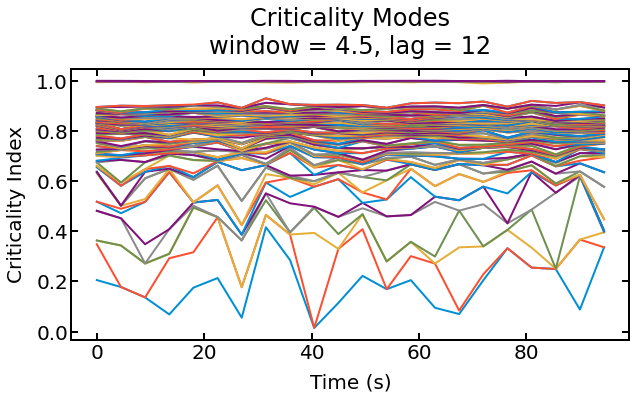

In [47]:
# plot mode criticalities
mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
for i, row in VAR_results.iterrows():
    mode_criticalities[i] = np.sort(row.criticality_inds)

for i in range(len(VAR_results.criticality_inds.iloc[0])):
    plt.plot(VAR_results.start_time, mode_criticalities[:, i])
plt.xlabel('Time (s)')
plt.ylabel('Criticality Index')
plt.title(f"Criticality Modes\nwindow = {window}, lag = {p}")
plt.show()

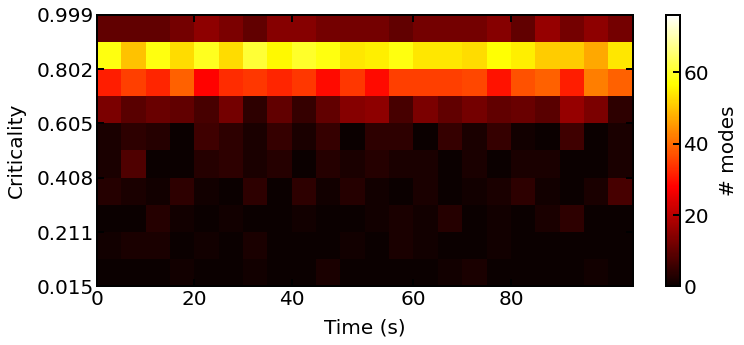

In [48]:
bin_nums = 10
bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
for t in range(VAR_results.criticality_inds.shape[0]):
    criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
T_max = VAR_results.criticality_inds.shape[0]*stride
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
im = plt.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 20)], [int(i) for i in np.arange(0, T_max, 20)])
ax.set_yticks(np.arange(0, bin_nums + 1, 2), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
cb = fig.colorbar(im, ax=ax)
cb.set_label(label='# modes')
plt.xlabel("Time (s)")
plt.ylabel("Criticality")
plt.show()

In [49]:
# standard_results = VAR_results.copy()
surrogate_results = VAR_results.copy()
# standard_results_v2 = VAR_results.copy()
# standard_results_v3 = VAR_results.copy()
# random_results = VAR_results.copy()
# flat_results = VAR_results.copy()
# normal_results = VAR_results.copy()
# mag_avg_results = VAR_results.copy()
# mag_avg_random_results = VAR_results.copy()
# mag_avg_flat_results = VAR_results.copy()
# sliding_avg_results = VAR_results.copy()

In [34]:
# Show Results

In [54]:
all_inds = np.hstack(standard_results.criticality_inds.to_numpy())
all_surrogate_inds = np.hstack(surrogate_results.criticality_inds.to_numpy())
# all_random_inds = np.hstack(random_results.criticality_inds.to_numpy())
# all_flat_inds = np.hstack(flat_results.criticality_inds.to_numpy())
# all_normal_inds = np.hstack(normal_results.criticality_inds.to_numpy())
# all_mag_avg_inds = np.hstack(mag_avg_results.criticality_inds.to_numpy())
# all_mag_avg_random_inds = np.hstack(mag_avg_random_results.criticality_inds.to_numpy())
# all_inds_v2 = np.hstack(standard_results_v2.criticality_inds.to_numpy())
# all_inds_v3 = np.hstack(standard_results_v3.criticality_inds.to_numpy())
# all_mag_avg_flat_inds = np.hstack(mag_avg_flat_results.criticality_inds.to_numpy())
# all_sliding_avg_inds = np.hstack(sliding_avg_results.criticality_inds.to_numpy())

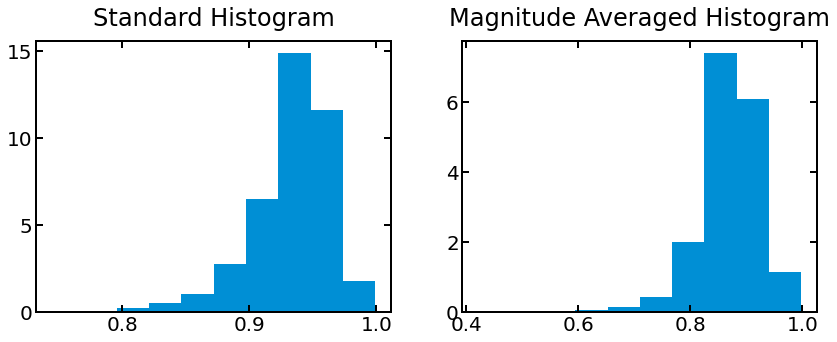

In [404]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title('Standard Histogram')
plt.hist(all_inds, density=True)
plt.subplot(1, 2, 2)
# plt.title('Random Phase Histogram')
# plt.hist(all_random_inds, density=True)
# plt.title('Flat Phase Histogram')
# plt.hist(all_flat_inds, density=True)
# plt.title('Normal Phase Histogram')
# plt.hist(all_normal_inds, density=True)
plt.title('Magnitude Averaged Histogram')
plt.hist(all_mag_avg_inds, density=True)
plt.show()

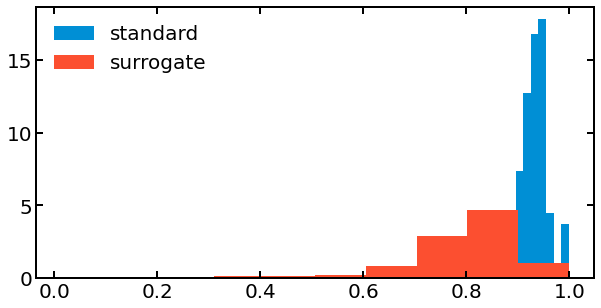

In [55]:
plt.hist(all_inds, density=True, label='standard')
plt.hist(all_surrogate_inds, density=True, label='surrogate')
# plt.hist(all_random_inds, density=True, label='random phase')
# plt.hist(all_flat_inds, density=True, label='flat phase')
# plt.hist(all_flat_inds, density=True, label='normal phase')
# plt.hist(all_normal_inds[all_normal_inds >= 0.8], density=True, label='normal phase')
# plt.hist(all_mag_avg_inds, density=True, label='mag averaged')
# plt.hist(all_mag_avg_random_inds, density=True, label='mag averaged uniform')
# plt.hist(all_inds_v2, density=True, label='standard v2')
# plt.hist(all_inds_v3, density=True, label='standard v3')
# plt.hist(all_mag_avg_flat_inds, density=True, label='mag averaged flat')
# plt.hist(all_sliding_avg_inds, density=True, label='sliding averaged')
plt.legend()
plt.show()

In [56]:
scipy.stats.mannwhitneyu(all_inds, all_surrogate_inds, alternative='greater')

MannwhitneyuResult(statistic=10118768.0, pvalue=0.0)

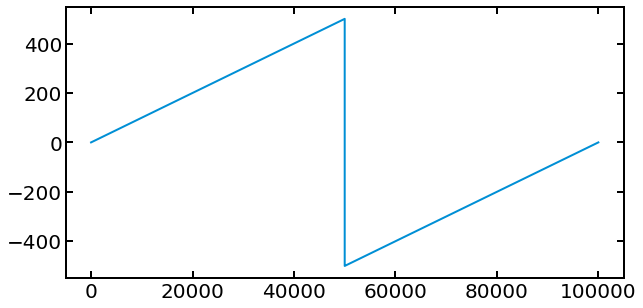

In [90]:
plt.plot(np.fft.fftfreq(signal_in.shape[0], d=0.001))

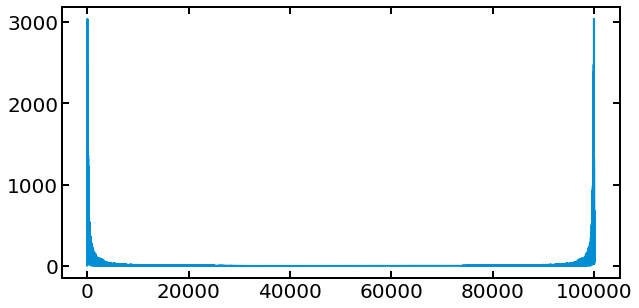

In [84]:
plt.plot(np.abs(np.fft.fft(signal_in[:, i])))

In [82]:
nperseg = 1000
i = 0
f, t, Zxx = scipy.signal.stft(signal_in[:, i], fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
f, t, Zxx_surrogate = scipy.signal.stft(signal_in_surrogate[:, i], fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)
f, t, Zxx_random = scipy.signal.stft(signal_in_random[:, i], fs=1/dt, window='hann', nperseg=nperseg, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=- 1)

In [78]:
((10*np.log10(np.abs(Zxx[:100])) - 10*np.log10(np.abs(Zxx_random[:100])))**2).mean(), ((10*np.log10(np.abs(Zxx[:100])) - 10*np.log10(np.abs(Zxx_surrogate[:100])))**2).mean()

(13.570271896063147, 21.964899539093363)

In [79]:
# plt.hist(((10*np.log10(np.abs(Zxx[:100])) - 10*np.log10(np.abs(Zxx_random[:100])))**2).flatten(), bins=50)
# plt.hist(((10*np.log10(np.abs(Zxx[:100])) - 10*np.log10(np.abs(Zxx_surrogate[:100])))**2).flatten(), bins=50)

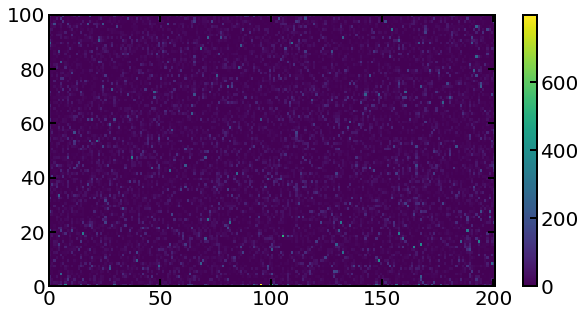

In [71]:
plt.pcolormesh((10*np.log10(np.abs(Zxx[:100])) - 10*np.log10(np.abs(Zxx_random[:100])))**2)
plt.colorbar()
plt.show()

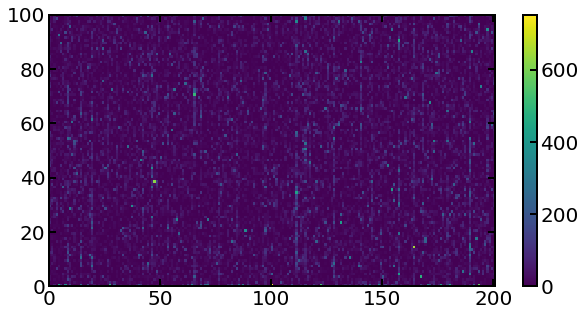

In [68]:
plt.pcolormesh((10*np.log10(np.abs(Zxx[:100])) - 10*np.log10(np.abs(Zxx_surrogate[:100])))**2)
plt.colorbar()
plt.show()

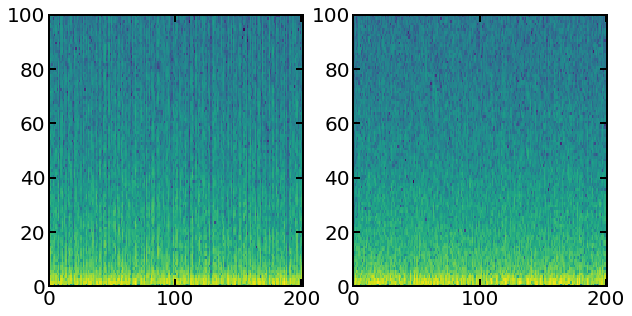

In [63]:
plt.subplot(1, 2, 1)
plt.pcolormesh(10*np.log10(np.abs(Zxx[:100])))
plt.subplot(1, 2, 2)
plt.pcolormesh(10*np.log10(np.abs(Zxx_surrogate[:100])))

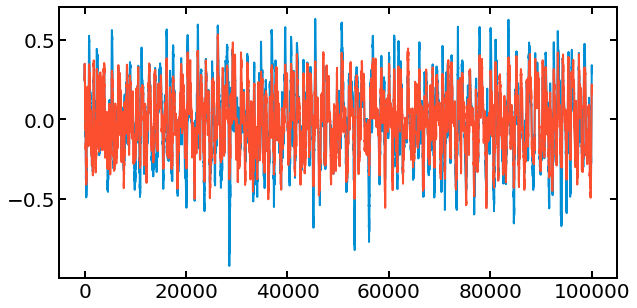

In [461]:
plt.plot(signal_in[:, indices[0]])
# plt.plot(signal_in_mag_avg[:, indices[0]])
# plt.plot(signal_in_mag_avg[:, indices[0]])
plt.plot(signal_in_sliding_avg[:, indices[0]])

In [462]:
correls = []
for ind in indices:
#     correls.append(scipy.stats.pearsonr(signal_in[:, ind], signal_in_mag_avg[:, ind])[0])
    correls.append(scipy.stats.pearsonr(signal_in[:, ind], signal_in_sliding_avg[:, ind])[0])

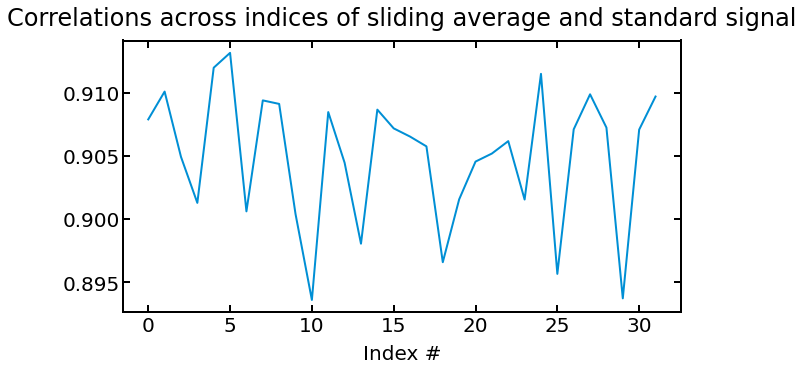

In [464]:
plt.plot(correls)
plt.xlabel('Index #')
plt.title('Correlations across indices of sliding average and standard signal')
plt.show()

IndexError: index 11 is out of bounds for axis 0 with size 11

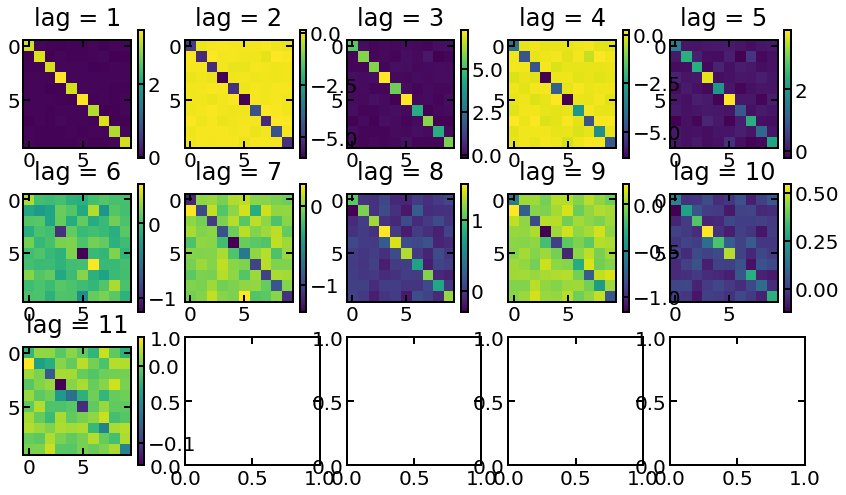

In [471]:
fig, axs = plt.subplots(3, 5, figsize=(14, 8))
for i in range(15):
    ax = axs[int(i/5)][i % 5]
    im = ax.imshow(mag_avg_random_results.coefs.iloc[0][i].T)
    ax.set_title(f"lag = {i + 1}")
    fig.colorbar(im, ax = ax)
plt.tight_layout()

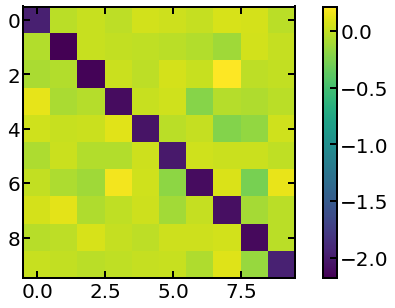

In [281]:
plt.imshow(shifted_results.coefs.iloc[0][i-1])
plt.colorbar()